In [1]:
import numpy as np
import time
from math import sqrt, pi, exp
import functools
import scipy
import matplotlib.pylab as pl
from varname import nameof


from utils.preconditioners import *
from utils.algorithms import *
from utils.functions import *

matplotlib.rcParams.update({'font.size': 18})


### Test case "Mixture of Gaussians" - 1 

(-6.0, 6.0, -6.0, 6.0)

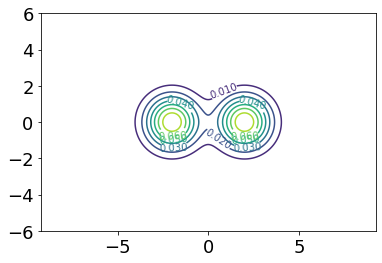

In [2]:
d = 2

y = np.zeros(1)
val = 6
xmin = -val
xmax = val
ymin= -val
ymax= val


# potential function
sigma = 1
gap = 4

#G = lambda u:  u[0] + u[1] # model
#Phi = lambda u: 0.5/(sigNoise**2)*(G(u)-y)**2 #likelihood


# also check:
#m1 = np.zeros((2, nb_grid, nb_grid))
#m2 = 3*np.ones((2, nb_grid, nb_grid))
#I1 = lambda u: 0.5*np.linalg.norm(u - m1,axis=0)**2 
#I2 = lambda u: 0.5*np.linalg.norm(u - m2,axis=0)**2

#also check  check https://stackoverflow.com/questions/72613164/plot-a-well-known-double-well-surface


# potential function
nb_grid = 200
#m1 = - np.ones((2, nb_grid, nb_grid))
#m2 = np.ones((2, nb_grid, nb_grid))
#I1 = lambda u: 0.5/(sigma**2)*np.linalg.norm(np.subtract(u, m1),axis=0)**2 # TODO: recoder ça bien
#I2 = lambda u: 0.5/(sigma**2)*np.linalg.norm(np.subtract(u, m2),axis=0)**2 

m1 = np.asarray([-1, 0]).reshape((2,1))
m2 = np.asarray([1, 0]).reshape((2,1))
I1 = lambda u: 0.5/(sigma**2)*((u[0] - gap/2)**2 + u[1]**2) # TODO: recoder ça bien
I2 = lambda u: 0.5/(sigma**2)*((u[0] + gap/2)**2 + u[1]**2)

I = lambda u: - np.log(np.exp(-I1(u)) + np.exp(-I2(u)))


# plot posterior

u0s = np.linspace(xmin, xmax, nb_grid) # draw a grid of nb_grid points in 2d
u1s = np.linspace(ymin, ymax, nb_grid)
U0, U1 = np.meshgrid(u0s,u1s)
U = np.stack((U0,U1)) # size (2, nb_grid, nb_grid)

unnorm_dens = np.exp(-I1(U)) + np.exp(-I2(U))

Z = np.trapz(unnorm_dens, u0s, axis=1)
Z = np.trapz(Z, u1s)
dens = unnorm_dens/Z # check the computation
#dens = unnorm_dens

marg_over_x = np.trapz(dens, u0s, axis=1)
marg_over_y = np.trapz(dens, u1s, axis=0)

plt.figure()
DS = plt.contour(U0, U1, dens) # plot normalized density  
plt.clabel(DS, inline=1, fontsize=10)
labels = ['post', 'post','post','post','post', 'post']
for i in range(len(labels)):
    DS.collections[i].set_label(labels[i])
plt.axis('equal')

### Try algorithms

In [3]:
# parameters of all the algorithms

J = 20  # number of particles 
N_sim = 1000 # number of iterations
d = 2 # dimension
tau = 1e-2 # step size

# parameters of our algorithm
const = 1.5 



Experiment 0
ULA: 9.580978870391846 seconds


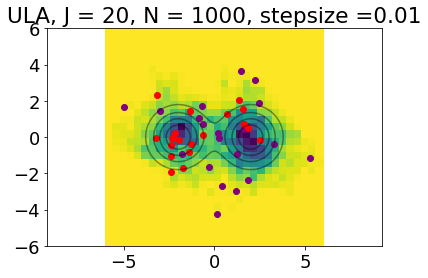

ALDI with gradient: 9.678352117538452 seconds


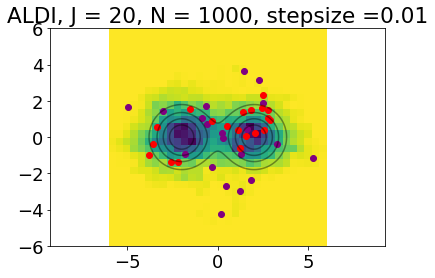

iter
0
lambda min
3.715711995413229


/Users/annakorba/Desktop/nreks/utils/algorithms.py:119: ComplexWarning: Casting complex values to real discards the imaginary part
  us_list_ALDINR[:, :, n+1] = us + tau * drift  + np.sqrt(tau) * diff


iter
500
lambda min
1.0786823561021008
ALDI NR: 9.734982252120972 seconds


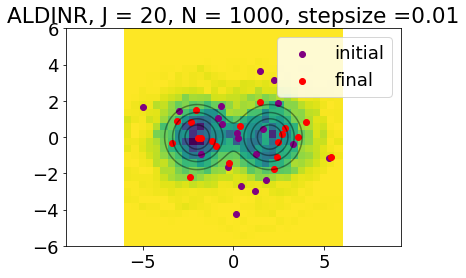


Experiment 1
ULA: 8.69526219367981 seconds


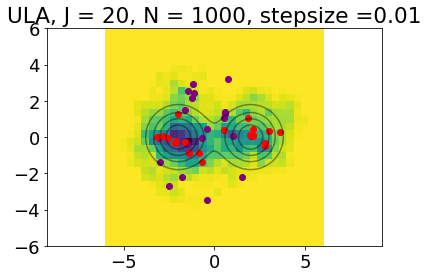

ALDI with gradient: 8.865730047225952 seconds


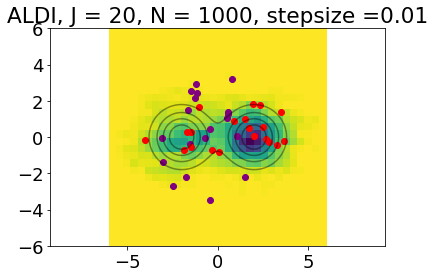

iter
0
lambda min
1.9466243332090147
iter
500
lambda min
1.23055128150662
ALDI NR: 9.256400108337402 seconds


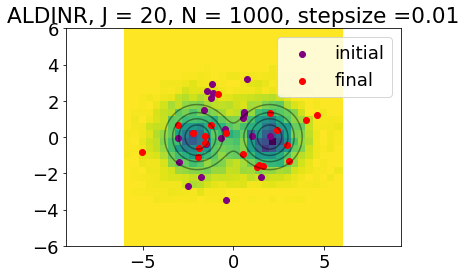


Experiment 2
ULA: 8.799329996109009 seconds


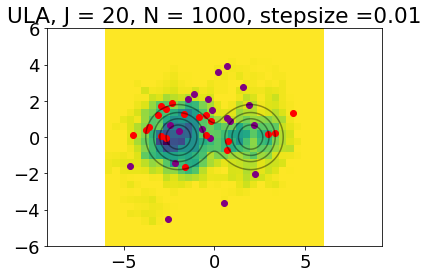

ALDI with gradient: 8.926398038864136 seconds


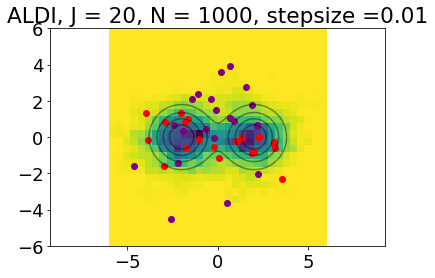

iter
0
lambda min
2.472562514771462
iter
500
lambda min
0.6252874775669469
ALDI NR: 9.291908264160156 seconds


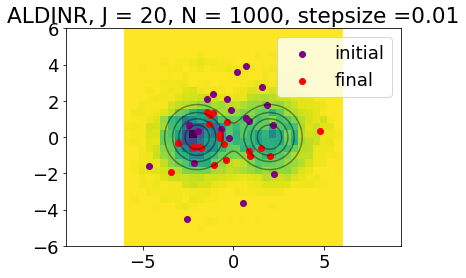

In [4]:

N_exp = 3

for j in range(N_exp):
    
    print()
    print("Experiment " +str(j))
    # resample initialization
    u0 = np.random.normal(0,2.0,(d,J)) 
    
    # ULA
    
    start_time = time.time()
    us_list_ULA = run_ULA(I, N_sim, u0, tau)
    np.save('save_data/mog/ULA_J_'+str(us_list_ULA.shape[1])+'_Nsim_'\
            +str(us_list_ULA.shape[2])+'_tau_'+str(tau)+'_Exp_'+str(j)+'.npy', us_list_ULA)
    print(f"ULA: {time.time()-start_time} seconds")

    name = nameof(us_list_ULA).lstrip('us_list')
    plot_results(I, us_list_ULA, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    plt.scatter(us_list_ULA[0, :, 0], us_list_ULA[1, :, 0],  color = "purple", label = 'initial')
    plt.scatter(us_list_ULA[0, :, -1], us_list_ULA[1, :, -1], color = "red", label = 'final')
    plt.show()
    
    
    # ALDI 
    start_time = time.time()
    us_list_ALDI = run_ALDI_with_gradient(I, N_sim, u0, tau)
    np.save('save_data/mog/ALDI_J_'+str(us_list_ALDI.shape[1])+'_Nsim_'\
                        +str(us_list_ALDI.shape[2])+'_tau_'+str(tau)+'_Exp_'+str(j)+'.npy', us_list_ALDI)
    print(f"ALDI with gradient: {time.time()-start_time} seconds")
    
    name = nameof(us_list_ALDI).lstrip('us_list')
    plot_results(I, us_list_ALDI, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    plt.scatter(us_list_ALDI[0, :, 0], us_list_ALDI[1, :, 0], color = "purple", label = 'initial')
    plt.scatter(us_list_ALDI[0, :, -1], us_list_ALDI[1, :, -1], color = "red", label = 'final')
    plt.show()
    
    
    
    # NRALDI (our scheme)
    # eventually new parameters like stepsize

    tau_ALDINR = tau
    start_time = time.time()
    us_list_ALDINR = run_ALDINR(I, N_sim, u0, tau_ALDINR, const) 
    np.save('save_data/mog/ALDINR_J_'\
                          +str(us_list_ALDINR.shape[1])+'_Nsim_'+str(us_list_ALDINR.shape[2])+'_tau_'+str(tau_ALDINR)+'_Exp_'+str(j)+'.npy', us_list_ALDINR)


    print(f"ALDI NR: {time.time()-start_time} seconds")

    name = nameof(us_list_ALDINR).lstrip('us_list')
    plot_results(I, us_list_ALDINR, tau_ALDINR, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    plt.scatter(us_list_ALDINR[0, :, 0], us_list_ALDINR[1, :, 0], color = "purple", label = 'initial')
    plt.scatter(us_list_ALDINR[0, :, -1], us_list_ALDINR[1, :, -1], color = "red", label = 'final')
    plt.legend()
    plt.show()
    


### Mixture of Gaussians 2 


Experiment 1
ULA: 9.154780864715576 seconds
ALDI with gradient: 9.780050039291382 seconds
iter
0
lambda min
0.8508647598431331
iter
500
lambda min
0.7673958482276889
ALDI NR: 10.661241054534912 seconds


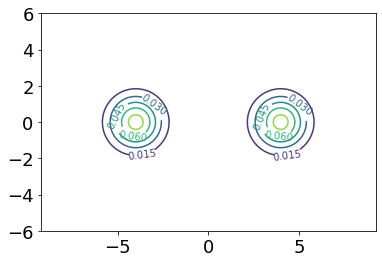

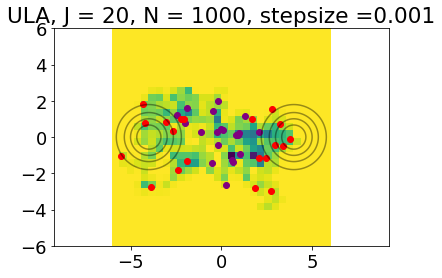

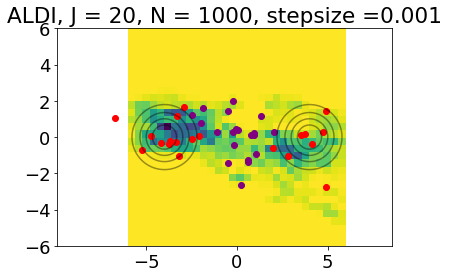

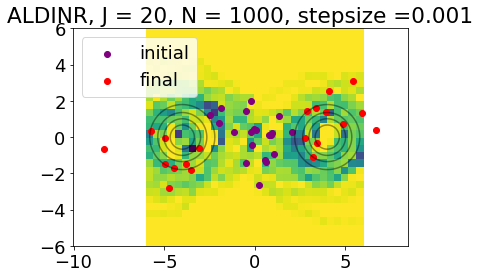


Experiment 1
ULA: 9.54083514213562 seconds
ALDI with gradient: 10.321761846542358 seconds
iter
0
lambda min
0.5096887302745409
iter
500
lambda min
1.5436242230604154
ALDI NR: 10.679828882217407 seconds


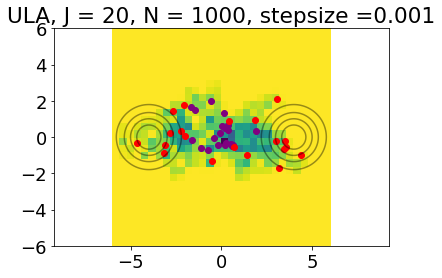

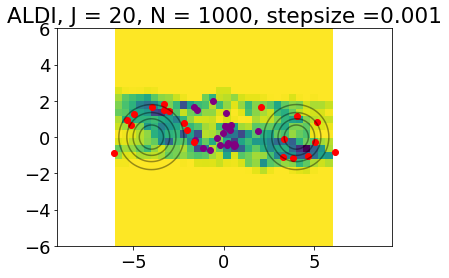

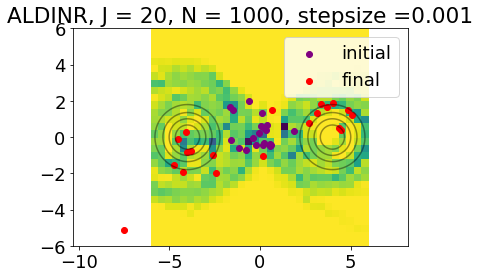


Experiment 1
ULA: 9.056771039962769 seconds
ALDI with gradient: 9.21595811843872 seconds
iter
0
lambda min
0.6118820872860994
iter
500
lambda min
2.1184724100621546
ALDI NR: 9.995450973510742 seconds


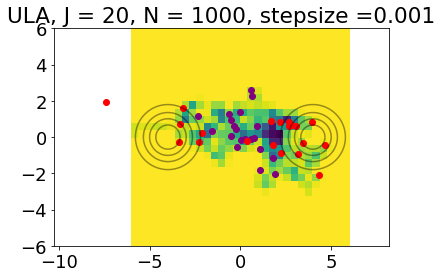

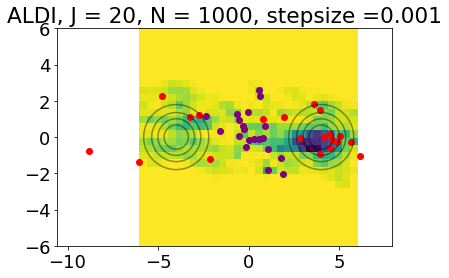

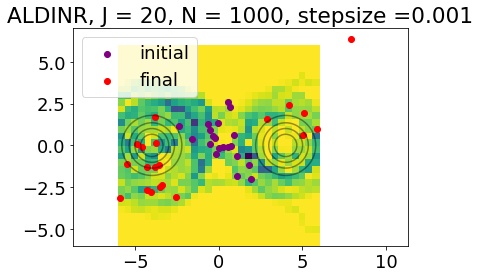

In [8]:
# with a bigger gap we have to take a smaller stepsize

d = 2

y = np.zeros(1)
val = 6
xmin = -val
xmax = val
ymin= -val
ymax= val


# potential function
sigma = 1
gap = 8

#G = lambda u:  u[0] + u[1] # model
#Phi = lambda u: 0.5/(sigNoise**2)*(G(u)-y)**2 #likelihood

# potential function
nb_grid = 200
#m1 = - np.ones((2, nb_grid, nb_grid))
#m2 = np.ones((2, nb_grid, nb_grid))
#I1 = lambda u: 0.5/(sigma**2)*np.linalg.norm(np.subtract(u, m1),axis=0)**2 # TODO: recoder ça bien
#I2 = lambda u: 0.5/(sigma**2)*np.linalg.norm(np.subtract(u, m2),axis=0)**2 

m1 = np.asarray([-1, 0]).reshape((2,1))
m2 = np.asarray([1, 0]).reshape((2,1))

I1 = lambda u: 0.5/(sigma**2)*((u[0] - gap/2)**2 + u[1]**2) # TODO: recoder ça bien
I2 = lambda u: 0.5/(sigma**2)*((u[0] + gap/2)**2 + u[1]**2)

I = lambda u: - np.log(np.exp(-I1(u)) + np.exp(-I2(u)))


# plot posterior

u0s = np.linspace(xmin, xmax, nb_grid) # draw a grid of nb_grid points in 2d
u1s = np.linspace(ymin, ymax, nb_grid)
U = np.meshgrid(u0s,u1s)
#U = np.stack((U0,U1)) # size (2, nb_grid, nb_grid)

unnorm_dens = np.exp(-I1(U)) + np.exp(-I2(U))

Z = np.trapz(unnorm_dens, u0s, axis=1)
Z = np.trapz(Z, u1s)
dens = unnorm_dens/Z # check the computation
#dens = unnorm_dens

marg_over_x = np.trapz(dens, u0s, axis=1)
marg_over_y = np.trapz(dens, u1s, axis=0)

plt.figure()
DS = plt.contour(U0, U1, dens) # plot normalized density  
plt.clabel(DS, inline=1, fontsize=10)
labels = ['post', 'post','post','post','post', 'post']
for i in range(len(labels)):
    DS.collections[i].set_label(labels[i])
plt.axis('equal')

# parameters of all the algorithms

J = 20  # number of particles 
N_sim = 1000 # number of iterations
d = 2 # dimension
tau = 1e-3 # step size

# parameters of our algorithm
const = 1.5 



N_exp = 3

for j in range(N_exp):
    
    print()
    print("Experiment 1")
    # resample initialization
    u0 = np.random.normal(0,1.0,(d,J)) 


    # ULA
    start_time = time.time()
    us_list_ULA = run_ULA(I, N_sim, u0, tau)
    np.save('save_data/mog/ULA_J_'+str(us_list_ULA.shape[1])+'_Nsim_'\
            +str(us_list_ULA.shape[2])+'_tau_'+str(tau)+'_Exp_'+str(j)+'.npy', us_list_ULA)
    print(f"ULA: {time.time()-start_time} seconds")

    # ALDI 
    start_time = time.time()
    us_list_ALDI = run_ALDI_with_gradient(I, N_sim, u0, tau)
    np.save('save_data/mog/ALDI_J_'+str(us_list_ALDI.shape[1])+'_Nsim_'\
                        +str(us_list_ALDI.shape[2])+'_tau_'+str(tau)+'_Exp_'+str(j)+'.npy', us_list_ALDI)
    print(f"ALDI with gradient: {time.time()-start_time} seconds")

    # NRALDI (our scheme)
    # eventually new parameters like stepsize

    tau_ALDINR = tau
    start_time = time.time()
    us_list_ALDINR = run_ALDINR(I, N_sim, u0, tau_ALDINR, const) 
    np.save('save_data/mog/ALDINR_J_'\
                          +str(us_list_ALDINR.shape[1])+'_Nsim_'+str(us_list_ALDINR.shape[2])+'_tau_'+str(tau_ALDINR)+'_Exp_'+str(j)+'.npy', us_list_ALDINR)


    print(f"ALDI NR: {time.time()-start_time} seconds")
    
    # plot results
    
    val_min = min(( np.min(us_list_ULA), np.min(us_list_ALDI)))
    val_max = max(( np.max(us_list_ULA), np.max(us_list_ALDI)))

    name = nameof(us_list_ULA).lstrip('us_list')
    plot_results(I, us_list_ULA, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    plt.scatter(us_list_ULA[0, :, 0], us_list_ULA[1, :, 0],  color = "purple", label = 'initial')
    plt.scatter(us_list_ULA[0, :, -1], us_list_ULA[1, :, -1], color = "red", label = 'final')


    name = nameof(us_list_ALDI).lstrip('us_list')
    plot_results(I, us_list_ALDI, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    plt.scatter(us_list_ALDI[0, :, 0], us_list_ALDI[1, :, 0], color = "purple", label = 'initial')
    plt.scatter(us_list_ALDI[0, :, -1], us_list_ALDI[1, :, -1], color = "red", label = 'final')

    name = nameof(us_list_ALDINR).lstrip('us_list')
    plot_results(I, us_list_ALDINR, tau_ALDINR, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    plt.scatter(us_list_ALDINR[0, :, 0], us_list_ALDINR[1, :, 0], color = "purple", label = 'initial')
    plt.scatter(us_list_ALDINR[0, :, -1], us_list_ALDINR[1, :, -1], color = "red", label = 'final')
    plt.legend()
    plt.show()




Experiment 1
ULA: 9.626829624176025 seconds
ALDI with gradient: 9.099821090698242 seconds
iter
0
lambda min
0.7154318807460132
iter
500
lambda min
1.068713838251977
ALDI NR: 9.41006588935852 seconds


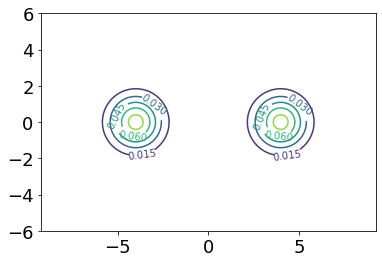

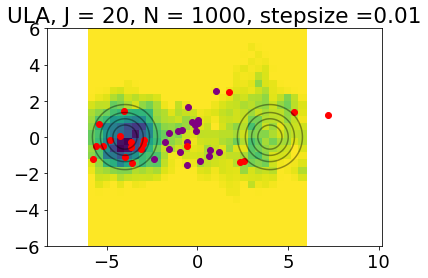

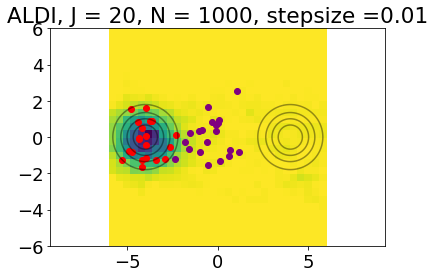

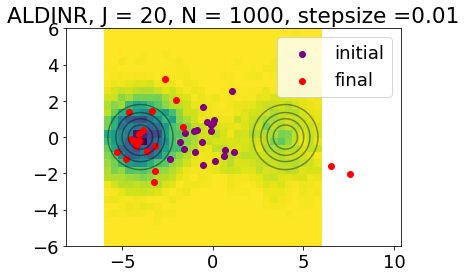


Experiment 1
ULA: 9.014746904373169 seconds
ALDI with gradient: 9.11714482307434 seconds
iter
0
lambda min
0.7470084849778085
iter
500
lambda min
1.87279063319043
ALDI NR: 9.936376810073853 seconds


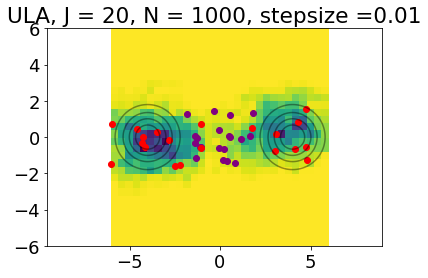

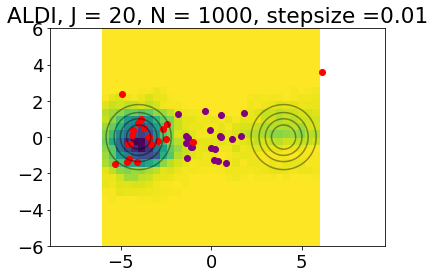

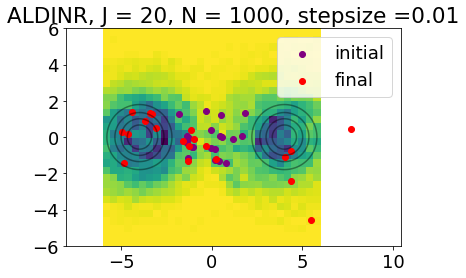


Experiment 1
ULA: 9.031854152679443 seconds
ALDI with gradient: 9.319154977798462 seconds
iter
0
lambda min
0.5529967199502064
iter
500
lambda min
4.3006020779872065


/var/folders/_t/h78tns5s2990dvmw2d6kzfyw0000gn/T/ipykernel_82661/1121267744.py:34: RuntimeWarning: divide by zero encountered in log
  I = lambda u: - np.log(np.exp(-I1(u)) + np.exp(-I2(u)))


ValueError: array must not contain infs or NaNs

In [9]:
# try again but a big step size but the computation of gradient log I is not nice
# it can diverge (but it can work very well and very fast as well - quitte ou double)

d = 2

y = np.zeros(1)
val = 6
xmin = -val
xmax = val
ymin= -val
ymax= val


# potential function
sigma = 1
gap = 8

#G = lambda u:  u[0] + u[1] # model
#Phi = lambda u: 0.5/(sigNoise**2)*(G(u)-y)**2 #likelihood

# potential function
nb_grid = 200
#m1 = - np.ones((2, nb_grid, nb_grid))
#m2 = np.ones((2, nb_grid, nb_grid))
#I1 = lambda u: 0.5/(sigma**2)*np.linalg.norm(np.subtract(u, m1),axis=0)**2 # TODO: recoder ça bien
#I2 = lambda u: 0.5/(sigma**2)*np.linalg.norm(np.subtract(u, m2),axis=0)**2 

m1 = np.asarray([-1, 0]).reshape((2,1))
m2 = np.asarray([1, 0]).reshape((2,1))

I1 = lambda u: 0.5/(sigma**2)*((u[0] - gap/2)**2 + u[1]**2) # TODO: recoder ça bien
I2 = lambda u: 0.5/(sigma**2)*((u[0] + gap/2)**2 + u[1]**2)

I = lambda u: - np.log(np.exp(-I1(u)) + np.exp(-I2(u)))


# plot posterior

u0s = np.linspace(xmin, xmax, nb_grid) # draw a grid of nb_grid points in 2d
u1s = np.linspace(ymin, ymax, nb_grid)
U = np.meshgrid(u0s,u1s)
#U = np.stack((U0,U1)) # size (2, nb_grid, nb_grid)

unnorm_dens = np.exp(-I1(U)) + np.exp(-I2(U))

Z = np.trapz(unnorm_dens, u0s, axis=1)
Z = np.trapz(Z, u1s)
dens = unnorm_dens/Z # check the computation
#dens = unnorm_dens

marg_over_x = np.trapz(dens, u0s, axis=1)
marg_over_y = np.trapz(dens, u1s, axis=0)

plt.figure()
DS = plt.contour(U0, U1, dens) # plot normalized density  
plt.clabel(DS, inline=1, fontsize=10)
labels = ['post', 'post','post','post','post', 'post']
for i in range(len(labels)):
    DS.collections[i].set_label(labels[i])
plt.axis('equal')

# parameters of all the algorithms

J = 20  # number of particles 
N_sim = 1000 # number of iterations
d = 2 # dimension
tau = 1e-2 # step size

# parameters of our algorithm
const = 1.5 



N_exp = 3

for j in range(N_exp):
    
    print()
    print("Experiment 1")
    # resample initialization
    u0 = np.random.normal(0,1.0,(d,J)) 


    # ULA
    start_time = time.time()
    us_list_ULA = run_ULA(I, N_sim, u0, tau)
    np.save('save_data/mog/ULA_J_'+str(us_list_ULA.shape[1])+'_Nsim_'\
            +str(us_list_ULA.shape[2])+'_tau_'+str(tau)+'_Exp_'+str(j)+'.npy', us_list_ULA)
    print(f"ULA: {time.time()-start_time} seconds")

    # ALDI 
    start_time = time.time()
    us_list_ALDI = run_ALDI_with_gradient(I, N_sim, u0, tau)
    np.save('save_data/mog/ALDI_J_'+str(us_list_ALDI.shape[1])+'_Nsim_'\
                        +str(us_list_ALDI.shape[2])+'_tau_'+str(tau)+'_Exp_'+str(j)+'.npy', us_list_ALDI)
    print(f"ALDI with gradient: {time.time()-start_time} seconds")

    # NRALDI (our scheme)
    # eventually new parameters like stepsize

    tau_ALDINR = tau
    start_time = time.time()
    us_list_ALDINR = run_ALDINR(I, N_sim, u0, tau_ALDINR, const) 
    np.save('save_data/mog/ALDINR_J_'\
                          +str(us_list_ALDINR.shape[1])+'_Nsim_'+str(us_list_ALDINR.shape[2])+'_tau_'+str(tau_ALDINR)+'_Exp_'+str(j)+'.npy', us_list_ALDINR)


    print(f"ALDI NR: {time.time()-start_time} seconds")
    
    # plot results
    
    val_min = min(( np.min(us_list_ULA), np.min(us_list_ALDI)))
    val_max = max(( np.max(us_list_ULA), np.max(us_list_ALDI)))

    name = nameof(us_list_ULA).lstrip('us_list')
    plot_results(I, us_list_ULA, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    plt.scatter(us_list_ULA[0, :, 0], us_list_ULA[1, :, 0],  color = "purple", label = 'initial')
    plt.scatter(us_list_ULA[0, :, -1], us_list_ULA[1, :, -1], color = "red", label = 'final')


    name = nameof(us_list_ALDI).lstrip('us_list')
    plot_results(I, us_list_ALDI, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    plt.scatter(us_list_ALDI[0, :, 0], us_list_ALDI[1, :, 0], color = "purple", label = 'initial')
    plt.scatter(us_list_ALDI[0, :, -1], us_list_ALDI[1, :, -1], color = "red", label = 'final')

    name = nameof(us_list_ALDINR).lstrip('us_list')
    plot_results(I, us_list_ALDINR, tau_ALDINR, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    plt.scatter(us_list_ALDINR[0, :, 0], us_list_ALDINR[1, :, 0], color = "purple", label = 'initial')
    plt.scatter(us_list_ALDINR[0, :, -1], us_list_ALDINR[1, :, -1], color = "red", label = 'final')
    plt.legend()
    plt.show()



## Plot some statistics for ALDINR


Experiment 1
ULA: 8.76680302619934 seconds
ALDI with gradient: 8.762567043304443 seconds
iter
0
lambda min
0.6274551893748959


/Users/annakorba/Desktop/nreks/utils/algorithms.py:119: ComplexWarning: Casting complex values to real discards the imaginary part
  us_list_ALDINR[:, :, n+1] = us + tau * drift  + np.sqrt(tau) * diff


iter
500
lambda min
0.8499460474430728
ALDI NR: 10.37495493888855 seconds


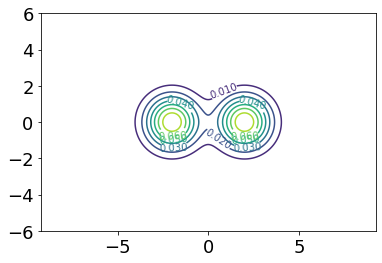

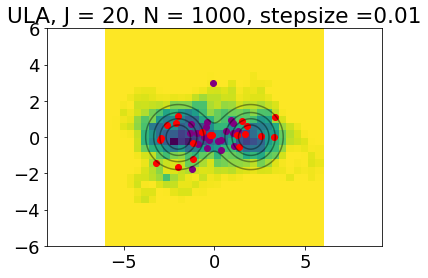

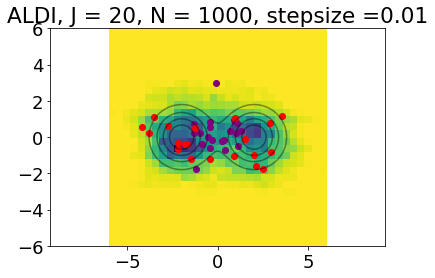

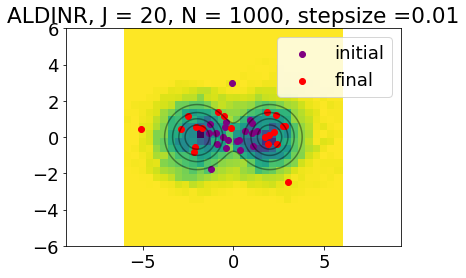

In [23]:
# choose one experiment that works, ie the first one (small gap big step size)

d = 2

y = np.zeros(1)
val = 6
xmin = -val
xmax = val
ymin= -val
ymax= val


# potential function
sigma = 1
gap = 4

#G = lambda u:  u[0] + u[1] # model
#Phi = lambda u: 0.5/(sigNoise**2)*(G(u)-y)**2 #likelihood

# potential function
nb_grid = 200
#m1 = - np.ones((2, nb_grid, nb_grid))
#m2 = np.ones((2, nb_grid, nb_grid))
#I1 = lambda u: 0.5/(sigma**2)*np.linalg.norm(np.subtract(u, m1),axis=0)**2 # TODO: recoder ça bien
#I2 = lambda u: 0.5/(sigma**2)*np.linalg.norm(np.subtract(u, m2),axis=0)**2 

m1 = np.asarray([-1, 0]).reshape((2,1))
m2 = np.asarray([1, 0]).reshape((2,1))

I1 = lambda u: 0.5/(sigma**2)*((u[0] - gap/2)**2 + u[1]**2) # TODO: recoder ça bien
I2 = lambda u: 0.5/(sigma**2)*((u[0] + gap/2)**2 + u[1]**2)

I = lambda u: - np.log(np.exp(-I1(u)) + np.exp(-I2(u)))


# plot posterior

u0s = np.linspace(xmin, xmax, nb_grid) # draw a grid of nb_grid points in 2d
u1s = np.linspace(ymin, ymax, nb_grid)
U = np.meshgrid(u0s,u1s)
#U = np.stack((U0,U1)) # size (2, nb_grid, nb_grid)

unnorm_dens = np.exp(-I1(U)) + np.exp(-I2(U))

Z = np.trapz(unnorm_dens, u0s, axis=1)
Z = np.trapz(Z, u1s)
dens = unnorm_dens/Z # check the computation
#dens = unnorm_dens

marg_over_x = np.trapz(dens, u0s, axis=1)
marg_over_y = np.trapz(dens, u1s, axis=0)

plt.figure()
DS = plt.contour(U0, U1, dens) # plot normalized density  
plt.clabel(DS, inline=1, fontsize=10)
labels = ['post', 'post','post','post','post', 'post']
for i in range(len(labels)):
    DS.collections[i].set_label(labels[i])
plt.axis('equal')

# parameters of all the algorithms

J = 20  # number of particles 
N_sim = 1000 # number of iterations
d = 2 # dimension
tau = 1e-2 # step size

# parameters of our algorithm
const = 1.5 


N_exp = 1

for j in range(N_exp):
    
    print()
    print("Experiment 1")
    # resample initialization
    u0 = np.random.normal(0,1.0,(d,J)) 


    # ULA
    start_time = time.time()
    us_list_ULA = run_ULA(I, N_sim, u0, tau)
    np.save('save_data/mog/ULA_J_'+str(us_list_ULA.shape[1])+'_Nsim_'\
            +str(us_list_ULA.shape[2])+'_tau_'+str(tau)+'_Exp_'+str(j)+'.npy', us_list_ULA)
    print(f"ULA: {time.time()-start_time} seconds")

    # ALDI 
    start_time = time.time()
    us_list_ALDI = run_ALDI_with_gradient(I, N_sim, u0, tau)
    np.save('save_data/mog/ALDI_J_'+str(us_list_ALDI.shape[1])+'_Nsim_'\
                        +str(us_list_ALDI.shape[2])+'_tau_'+str(tau)+'_Exp_'+str(j)+'.npy', us_list_ALDI)
    print(f"ALDI with gradient: {time.time()-start_time} seconds")

    # NRALDI (our scheme)
    # eventually new parameters like stepsize

    tau_ALDINR = tau
    start_time = time.time()
    us_list_ALDINR = run_ALDINR(I, N_sim, u0, tau_ALDINR, const) 
    np.save('save_data/mog/ALDINR_J_'\
                          +str(us_list_ALDINR.shape[1])+'_Nsim_'+str(us_list_ALDINR.shape[2])+'_tau_'+str(tau_ALDINR)+'_Exp_'+str(j)+'.npy', us_list_ALDINR)


    print(f"ALDI NR: {time.time()-start_time} seconds")
    
    # plot results
    
    val_min = min(( np.min(us_list_ULA), np.min(us_list_ALDI)))
    val_max = max(( np.max(us_list_ULA), np.max(us_list_ALDI)))

    name = nameof(us_list_ULA).lstrip('us_list')
    plot_results(I, us_list_ULA, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    plt.scatter(us_list_ULA[0, :, 0], us_list_ULA[1, :, 0],  color = "purple", label = 'initial')
    plt.scatter(us_list_ULA[0, :, -1], us_list_ULA[1, :, -1], color = "red", label = 'final')


    name = nameof(us_list_ALDI).lstrip('us_list')
    plot_results(I, us_list_ALDI, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    plt.scatter(us_list_ALDI[0, :, 0], us_list_ALDI[1, :, 0], color = "purple", label = 'initial')
    plt.scatter(us_list_ALDI[0, :, -1], us_list_ALDI[1, :, -1], color = "red", label = 'final')

    name = nameof(us_list_ALDINR).lstrip('us_list')
    plot_results(I, us_list_ALDINR, tau_ALDINR, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    plt.scatter(us_list_ALDINR[0, :, 0], us_list_ALDINR[1, :, 0], color = "purple", label = 'initial')
    plt.scatter(us_list_ALDINR[0, :, -1], us_list_ALDINR[1, :, -1], color = "red", label = 'final')
    plt.legend()
    plt.show()



In [24]:
# compute means and covariances

J = us_list_ULA.shape[1]
N_sim = us_list_ULA.shape[2]


means_ULA = np.mean(us_list_ULA, axis = 1)
means_ALDI = np.mean(us_list_ALDI, axis = 1)
means_ALDINR = np.mean(us_list_ALDINR, axis = 1)


covariances_ULA = np.ones((d, d, N_sim))
for i in range(N_sim):
    covariances_ULA[:,:, i] = np.cov(us_list_ULA[:, :, i])*(J-1)/J
 
covariances_ALDI = np.ones((d, d, N_sim))
for i in range(N_sim):
    covariances_ALDI[:,:, i] = np.cov(us_list_ALDI[:, :, i])*(J-1)/J

covariances_ALDINR = np.ones((d, d, N_sim))
for i in range(N_sim):
    covariances_ALDINR[:,:, i] = np.cov(us_list_ALDINR[:, :, i])*(J-1)/J

Text(0.5, 1.0, 'Distance to mean (|| mean(particles) - mean(target)||)')

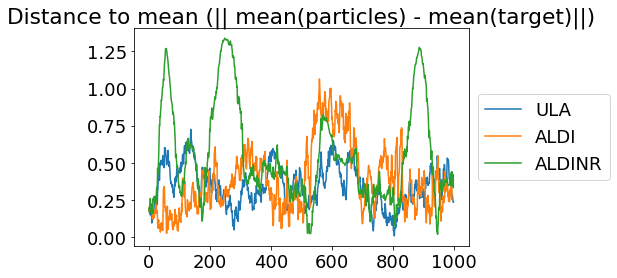

In [25]:
distances_to_mean_ULA = np.linalg.norm(means_ULA, axis=0)
plt.plot(distances_to_mean_ULA, label = 'ULA' )

distances_to_mean_ALDI = np.linalg.norm(means_ALDI, axis=0)
plt.plot(distances_to_mean_ALDI, label = 'ALDI' )

distances_to_mean_ALDINR = np.linalg.norm(means_ALDINR, axis=0)
plt.plot(distances_to_mean_ALDINR, label = 'ALDINR')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Distance to mean (|| mean(particles) - mean(target)||)')

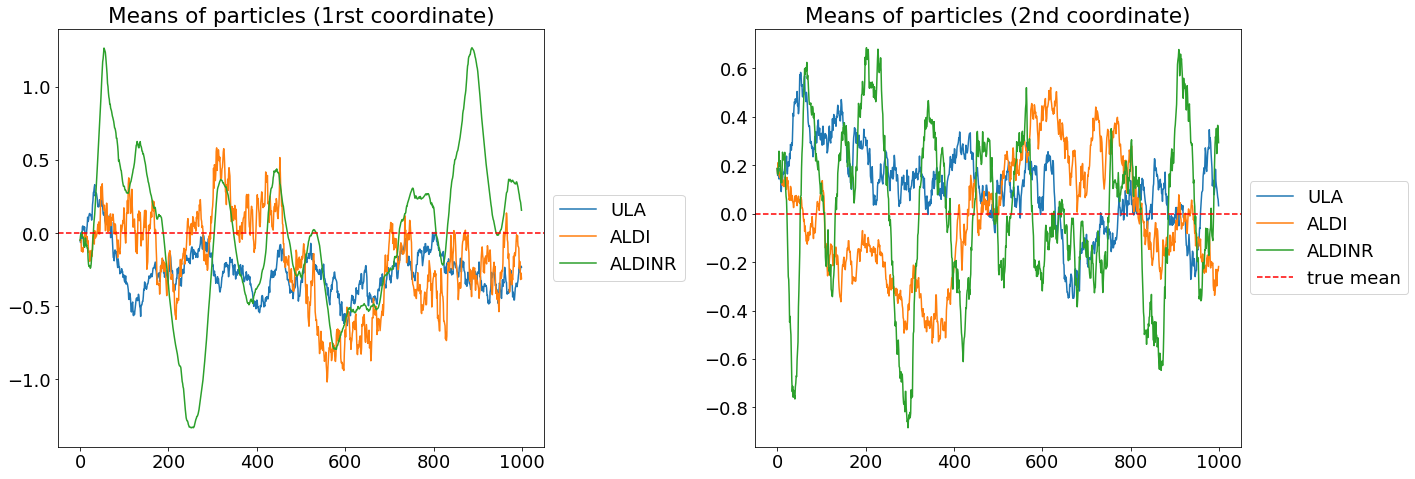

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(7)
fig.set_figwidth(20)

plt.subplot(1, 2, 1)

plt.plot(means_ULA[0, :], label = 'ULA' )
plt.plot(means_ALDI[0, :], label = 'ALDI' )
plt.plot(means_ALDINR[0, :], label = 'ALDINR')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.title('Means of particles (1rst coordinate)')

plt.subplot(1, 2, 2)
plt.plot(means_ULA[1, :], label = 'ULA' )
plt.plot(means_ALDI[1, :], label = 'ALDI' )
plt.plot(means_ALDINR[1, :], label = 'ALDINR')
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Means of particles (2nd coordinate)')
plt.tight_layout()

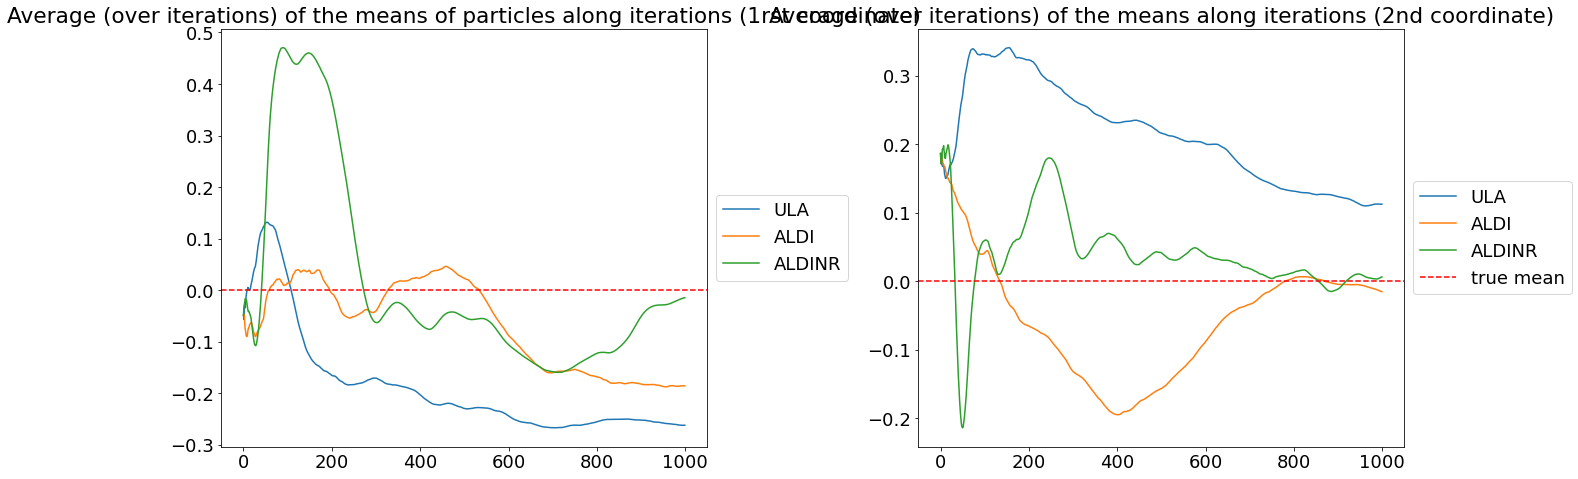

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(7)
fig.set_figwidth(20)


average_means_ULA = np.asarray([np.mean(means_ULA[:, :i], axis = 1) for i in range(1, N_sim + 1)])
average_means_ALDI =  np.asarray([np.mean(means_ALDI[:, :i], axis = 1) for i in range(1, N_sim + 1)])
average_means_ALDINR = np.asarray([np.mean(means_ALDINR[:, :i], axis = 1) for i in range(1, N_sim + 1)])

plt.subplot(1, 2, 1)
plt.plot(average_means_ULA[:, 0], label = 'ULA' )
plt.plot(average_means_ALDI[:, 0], label = 'ALDI' )
plt.plot(average_means_ALDINR[:, 0], label = 'ALDINR')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.title('Average (over iterations) of the means of particles along iterations (1rst coordinate)')

plt.subplot(1, 2, 2)
plt.plot(average_means_ULA[:, 1], label = 'ULA' )
plt.plot(average_means_ALDI[:, 1], label = 'ALDI' )
plt.plot(average_means_ALDINR[:, 1], label = 'ALDINR')
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Average (over iterations) of the means along iterations (2nd coordinate)')
plt.tight_layout()

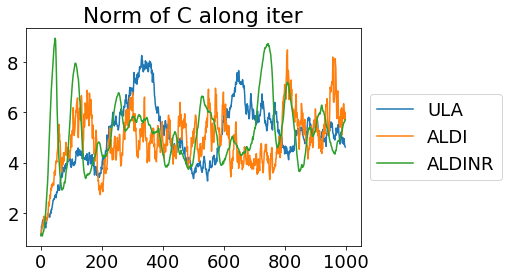

In [28]:
distances_to_covariances_ULA = np.asarray([np.linalg.norm(covariances_ULA[:, :, i]) for i in range(covariances_ULA.shape[2])])
plt.plot(distances_to_covariances_ULA, label ='ULA')

distances_to_covariances_ALDI = np.asarray([np.linalg.norm(covariances_ALDI[:, :, i]) for i in range(covariances_ALDI.shape[2])])
plt.plot(distances_to_covariances_ALDI, label ='ALDI')

distances_to_covariances_ALDINR = np.asarray([np.linalg.norm(covariances_ALDINR[:, :, i]) for i in range(covariances_ALDINR.shape[2])])
plt.plot(distances_to_covariances_ALDINR, label ='ALDINR')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Norm of C along iter')
plt.show()

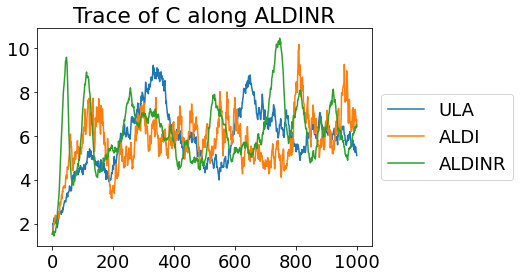

In [29]:
traces_of_C_ULA = np.asarray([np.trace(covariances_ULA[:, :, i]) for  i in range(covariances_ULA.shape[2])] )
traces_of_C_ALDI = np.asarray([np.trace(covariances_ALDI[:, :, i]) for  i in range(covariances_ALDI.shape[2])] )
traces_of_C_ALDINR = np.asarray([np.trace(covariances_ALDINR[:, :, i]) for  i in range(covariances_ALDINR.shape[2])] )

plt.plot(traces_of_C_ULA, label ='ULA')
plt.plot(traces_of_C_ALDI, label ='ALDI')
plt.plot(traces_of_C_ALDINR, label ='ALDINR')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Trace of C along ALDINR')
plt.show()

### marginal of distribution of particles on last iterations

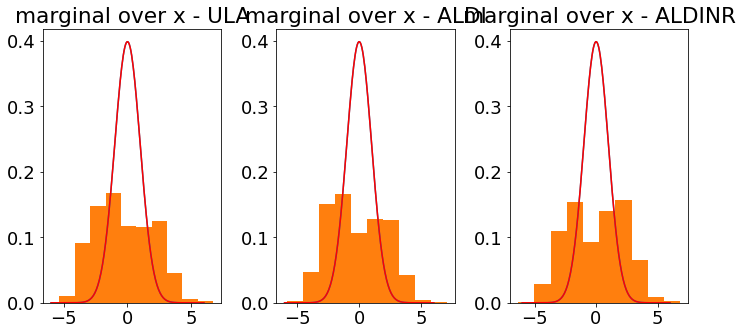

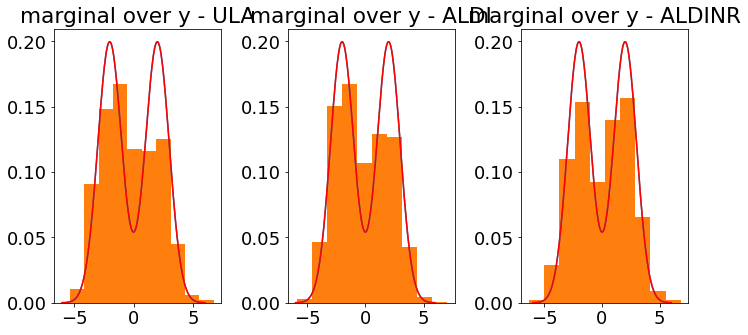

In [30]:
binsx = np.linspace(xmin,xmax,31)
binsy = np.linspace(ymin,ymax,31)

# marginal over x

fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(5)
fig.set_figwidth(10)

plt.subplot(1,3,1)
plt.plot(u0s, marg_over_x)
plt.hist(us_list_ULA[0,:,0:].flatten(), density=True)
plt.plot(u0s, marg_over_x, color = 'red')
plt.title('marginal over x - ULA')

plt.subplot(1,3,2)
plt.plot(u0s, marg_over_x)
plt.hist(us_list_ALDI[0,:,0:].flatten(), density=True)
plt.plot(u0s, marg_over_x, color = 'red')
plt.title('marginal over x - ALDI')

plt.subplot(1,3,3)
plt.plot(u0s, marg_over_x)
plt.hist(us_list_ALDINR[0,:,0:].flatten(), density=True)
plt.plot(u0s, marg_over_x, color = 'red')
plt.title('marginal over x - ALDINR')
fig.tight_layout()

# marginal over y

fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(5)
fig.set_figwidth(10)

plt.subplot(1,3,1)
plt.plot(u0s, marg_over_y)
plt.hist(us_list_ULA[0,:,0:].flatten(), density=True)
plt.plot(u0s, marg_over_y, color = 'red')
plt.title('marginal over y - ULA')

plt.subplot(1,3,2)
plt.plot(u0s, marg_over_y)
plt.hist(us_list_ALDI[0,:,0:].flatten(), density=True)
plt.plot(u0s, marg_over_y, color = 'red')
plt.title('marginal over y - ALDI')

plt.subplot(1,3,3)
plt.plot(u0s, marg_over_y)
plt.hist(us_list_ALDINR[0,:,0:].flatten(), density=True)
plt.plot(u0s, marg_over_y, color = 'red')
plt.title('marginal over y - ALDINR')
plt.tight_layout()

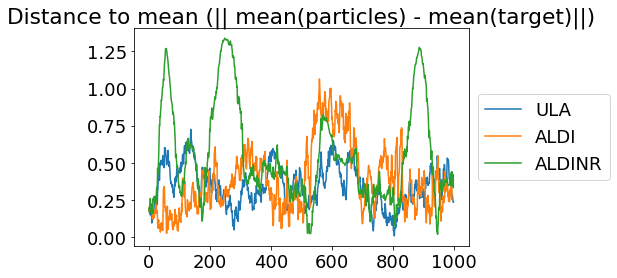

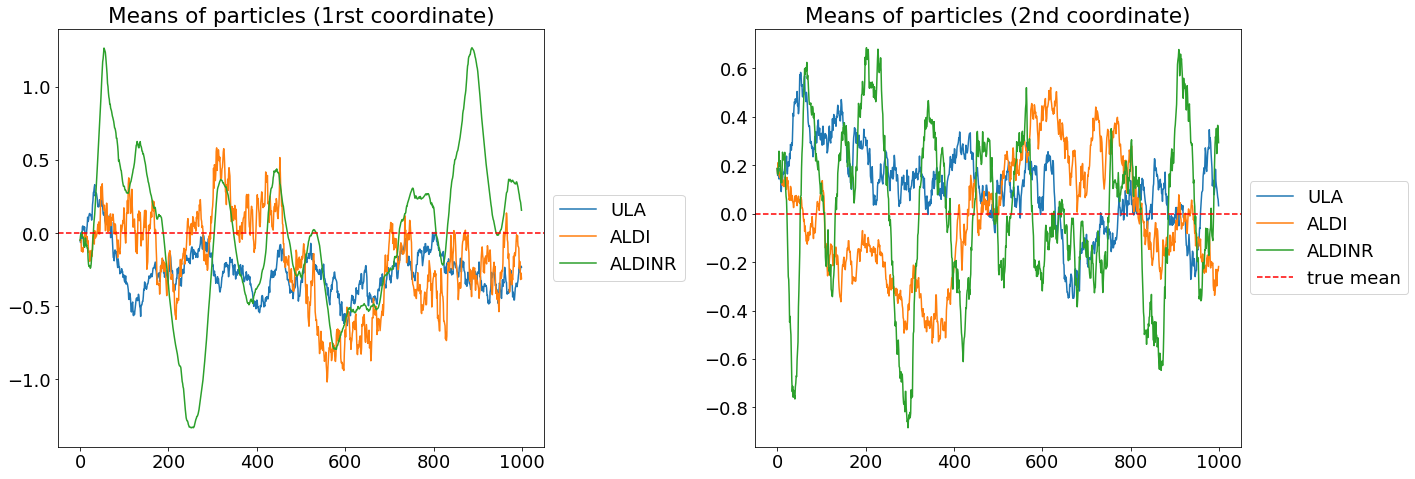

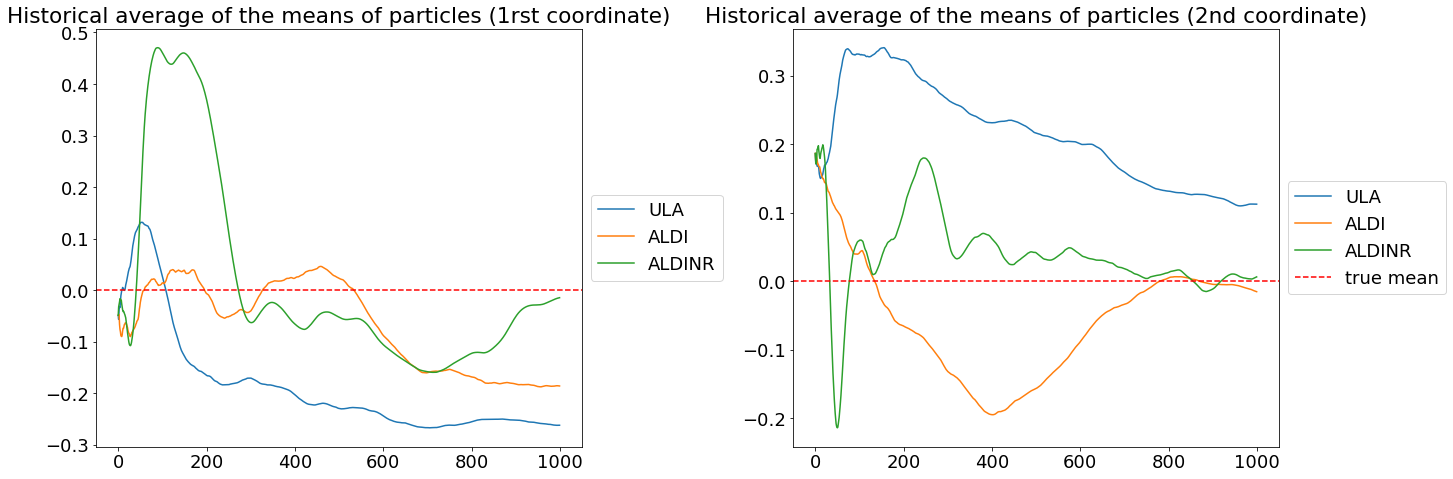

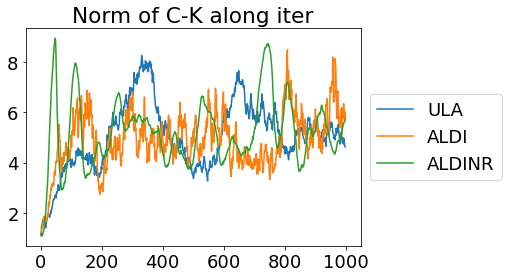

In [31]:
j = 0

# load data

# compute means and covariances
J = us_list_ULA.shape[1]
N_sim = us_list_ULA.shape[2]


means_ULA = np.mean(us_list_ULA, axis = 1)
means_ALDI = np.mean(us_list_ALDI, axis = 1)
means_ALDINR = np.mean(us_list_ALDINR, axis = 1)

covariances_ULA = np.ones((d, d, N_sim))
for i in range(N_sim):
    covariances_ULA[:,:, i] = np.cov(us_list_ULA[:, :, i])*(J-1)/J
 
covariances_ALDI = np.ones((d, d, N_sim))
for i in range(N_sim):
    covariances_ALDI[:,:, i] = np.cov(us_list_ALDI[:, :, i])*(J-1)/J

covariances_ALDINR = np.ones((d, d, N_sim))
for i in range(N_sim):
    covariances_ALDINR[:,:, i] = np.cov(us_list_ALDINR[:, :, i])*(J-1)/J
    
# plot distances to target mean
distances_to_mean_ULA = np.linalg.norm(means_ULA, axis=0)
plt.plot(distances_to_mean_ULA, label = 'ULA' )

distances_to_mean_ALDI = np.linalg.norm(means_ALDI, axis=0)
plt.plot(distances_to_mean_ALDI, label = 'ALDI' )

distances_to_mean_ALDINR = np.linalg.norm(means_ALDINR, axis=0)
plt.plot(distances_to_mean_ALDINR, label = 'ALDINR')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Distance to mean (|| mean(particles) - mean(target)||)')

# plot means of particles along iterations

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(7)
fig.set_figwidth(20)

plt.subplot(1, 2, 1)
plt.plot(means_ULA[0, :], label = 'ULA' )
plt.plot(means_ALDI[0, :], label = 'ALDI' )
plt.plot(means_ALDINR[0, :], label = 'ALDINR')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.title('Means of particles (1rst coordinate)')

plt.subplot(1, 2, 2)
plt.plot(means_ULA[1, :], label = 'ULA' )
plt.plot(means_ALDI[1, :], label = 'ALDI' )
plt.plot(means_ALDINR[1, :], label = 'ALDINR')
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Means of particles (2nd coordinate)')
plt.tight_layout()
plt.show()

# plot historical average (i.e. over iterations) of means of particles

average_means_ULA = np.asarray([np.mean(means_ULA[:, :i], axis = 1) for i in range(1, N_sim + 1)])
average_means_ALDI =  np.asarray([np.mean(means_ALDI[:, :i], axis = 1) for i in range(1, N_sim + 1)])
average_means_ALDINR = np.asarray([np.mean(means_ALDINR[:, :i], axis = 1) for i in range(1, N_sim + 1)])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
#fig.set_figheight(7)
#fig.set_figwidth(20)

plt.subplot(1, 2, 1)
plt.plot(average_means_ULA[:, 0], label = 'ULA' )
plt.plot(average_means_ALDI[:, 0], label = 'ALDI' )
plt.plot(average_means_ALDINR[:, 0], label = 'ALDINR')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.title('Historical average of the means of particles (1rst coordinate)')

plt.subplot(1, 2, 2)
plt.plot(average_means_ULA[:, 1], label = 'ULA' )
plt.plot(average_means_ALDI[:, 1], label = 'ALDI' )
plt.plot(average_means_ALDINR[:, 1], label = 'ALDINR')
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Historical average of the means of particles (2nd coordinate)')
plt.tight_layout()
plt.show()

distances_to_covariances_ULA = np.asarray([np.linalg.norm(covariances_ULA[:, :, i]) for i in range(covariances_ULA.shape[2])])
plt.plot(distances_to_covariances_ULA, label ='ULA')

distances_to_covariances_ALDI = np.asarray([np.linalg.norm(covariances_ALDI[:, :, i]) for i in range(covariances_ALDI.shape[2])])
plt.plot(distances_to_covariances_ALDI, label ='ALDI')

distances_to_covariances_ALDINR = np.asarray([np.linalg.norm(covariances_ALDINR[:, :, i]) for i in range(covariances_ALDINR.shape[2])])
plt.plot(distances_to_covariances_ALDINR, label ='ALDINR')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Norm of C-K along iter')
plt.show()